### Identification of compounds that target the reference sequence of the tyrosine-protein kinase active site.
### Following identification of PDB 2HYY as an ABL tyrosine kinase inhibitor, I took the UniProt ID from that entry for the target.
### nglview is a really great module for visualing structures of many types in a Jupyter notebook, so we have a look at imatinib and the PDB entry 2HYY.
### I go through the process of getting bioactivity data for compounds ranked by pIC50 for the target.
### There is a summary of my conclusions at the bottom of this notebook.
### This and other notebooks all follow the CADD tutorials for using ChEMBL and RDKit [here](https://projects.volkamerlab.org/teachopencadd/index.html).
### Please note that I make liberal use of well-written code that already exists, especially from the link immediately above.

In [52]:
import math
import nglview as nv
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [53]:
# SMILES format for ligand from assignment document
smiles_code = "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5"

In [54]:
# Add hydrogens to the skeleton
molecule = Chem.AddHs(Chem.MolFromSmiles(smiles_code))

In [55]:
# Sanity check, imatinib should have 68 atoms after adding hydrogens
molecule.GetNumAtoms()

68

In [56]:
# We need to create an embedded molecule instance in order to use nglview
AllChem.EmbedMolecule(molecule)
view = nv.show_rdkit(molecule)
view

NGLWidget()

In [59]:
# Let's look at PDB ID 2HYY, this is very cool to do in a Jupyter notebook!
view = nv.show_pdbid('2HYY')
view

NGLWidget()

In [2]:
# Instantiate handles for interacting with ChEMBL
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [51]:
# After looking at RCSB for imatinib crystallized with a tyrosine kinase inhibitor (imatinib),
# I chose a target from PDB ID 2HYY, which has a UniProt ID P00519
uniprot_id = 'P00519'

In [4]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [5]:
# Get potential targets from ChEMBL
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL1862,SINGLE PROTEIN
1,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL1862,SINGLE PROTEIN
2,Homo sapiens,Bcr/Abl fusion protein,CHEMBL2096618,CHIMERIC PROTEIN
3,Homo sapiens,Tyrosine-protein kinase ABL,CHEMBL2111414,PROTEIN FAMILY
4,Homo sapiens,Ras and Rab interactor 1/Tyrosine-protein kina...,CHEMBL3885630,PROTEIN-PROTEIN INTERACTION
5,Homo sapiens,Transcription factor ETV6/Tyrosine-protein kin...,CHEMBL3885645,CHIMERIC PROTEIN
6,Homo sapiens,Baculoviral IAP repeat-containing protein 2/BC...,CHEMBL4296119,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,E3 ubiquitin-protein ligase XIAP/BCR/ABL,CHEMBL4296120,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Cereblon/BCR/ABL,CHEMBL4296137,PROTEIN-PROTEIN INTERACTION
9,Homo sapiens,VHL/ABL1,CHEMBL4523725,PROTEIN-PROTEIN INTERACTION


In [6]:
# I'm choosing CHEMBL1862, it's single protein and representative of the Bcr-Abl TKI
target = targets.iloc[0]
target

organism                           Homo sapiens
pref_name           Tyrosine-protein kinase ABL
target_chembl_id                     CHEMBL1862
target_type                      SINGLE PROTEIN
Name: 0, dtype: object

In [7]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL1862


In [8]:
# Get binding assay data
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 2197, <class 'chembl_webresource_client.query_set.QuerySet'>


In [9]:
# Look at an entry in bioactivities
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 146141,
 'assay_chembl_id': 'CHEMBL806527',
 'assay_description': 'Radioligand displacement assay for the binding of [125I]Glu-Pro-Gln-pTyr-Glu-Glu-Ile-Pro-Ile-Tyr-Leu to ABL SH2 domain',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL13462',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '4000.0',
 'target_chembl_id': 'CHEMBL1862',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '4.0'}

In [10]:
# Get the query set from ChEMBL
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (2198, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50,uM,4.0
1,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50,uM,4.0
2,146143,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL13462,=,nM,16000.0,CHEMBL1862,Homo sapiens,IC50,uM,16.0
3,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50,uM,15.0
4,148571,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL414123,=,nM,2900.0,CHEMBL1862,Homo sapiens,IC50,uM,2.9


In [11]:
# We need to clean-up the bioactivites data and do some pandas calisthenics
bioactivities_df["units"].unique()  # Illustrated here, see output
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
2,146143,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL13462,=,nM,16000.0,CHEMBL1862,Homo sapiens,IC50
3,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,148571,CHEMBL762575,Inhibition of [35S]-labeled SH2-GST Abl bindin...,B,CHEMBL414123,=,nM,2900.0,CHEMBL1862,Homo sapiens,IC50


In [12]:
# These steps are required per T001 to further manage the dataframe
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})  # This needs to be a float, not an object
bioactivities_df.dropna(axis=0, how="any", inplace=True)  # Delete entries with missing values
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]  # Keep only entries with nM units
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)  # Delete duplicate molecules
bioactivities_df.reset_index(drop=True, inplace=True)  # Reset the index
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
2,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50
3,154553,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL301845,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,159483,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL58478,=,nM,1700.0,CHEMBL1862,Homo sapiens,IC50


In [13]:
# Rename the columns
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)

In [14]:
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,146141,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL13462,=,nM,4000.0,CHEMBL1862,Homo sapiens,IC50
1,148569,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL414123,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
2,152122,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL413629,=,nM,1800.0,CHEMBL1862,Homo sapiens,IC50
3,154553,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL301845,=,nM,15000.0,CHEMBL1862,Homo sapiens,IC50
4,159483,CHEMBL806527,Radioligand displacement assay for the binding...,B,CHEMBL58478,=,nM,1700.0,CHEMBL1862,Homo sapiens,IC50


In [16]:
# This yields 1420 molecules and IC50 values for the target
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (1420, 11)


In [17]:
# Make a filter to get ID and structures only from ChEMBL
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [18]:
# Download compounds, display progress bar
compounds = list(tqdm(compounds_provider))

  0%|          | 0/1420 [00:00<?, ?it/s]

In [20]:
# Have a look at the compounds
compounds_df = pd.DataFrame.from_records(
    compounds,
)
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL44,{'canonical_smiles': 'O=c1c(-c2ccc(O)cc2)coc2c...
1,CHEMBL9514,{'canonical_smiles': 'COC(=O)Nc1nc2ccc(C(=O)c3...
2,CHEMBL13462,{'canonical_smiles': 'CC(=O)N[C@@H](Cc1ccc(OP(...
3,CHEMBL276711,{'canonical_smiles': 'Cc1cc(C)c(/C=C2\C(=O)Nc3...
4,CHEMBL535,{'canonical_smiles': 'CCN(CC)CCNC(=O)c1c(C)[nH...


In [21]:
# As before, clean the data
compounds_df.dropna(axis=0, how="any", inplace=True)  # Drop rows with no structure
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)  # Remove duplicates

In [22]:
# What representations do we have?
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [23]:
# We want to keep only those of the form 'canonical_smiles'
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1418, 2)


In [24]:
# Make sure we got them all
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (1418, 2)


In [36]:
# Join bioactivites and compounds on the 'molecule_chembl_id'; keep IC50, ID, units
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")  # Our output dataset has 1418 entries

Dataset with 1418 entries.


In [37]:
# Have a look at data types and the output
print(output_df.dtypes)
output_df.head(10)

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object


,molecule_chembl_id,IC50,units,smiles
0,CHEMBL13462,4000.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL414123,15000.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
2,CHEMBL413629,1800.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...
3,CHEMBL301845,15000.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...
4,CHEMBL58478,1700.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...
5,CHEMBL298813,1600.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc...
6,CHEMBL293803,4900.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
7,CHEMBL294692,1200.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...
8,CHEMBL294420,1200.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...
9,CHEMBL299477,7900.0,nM,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...


In [38]:
# Function for getting pIC50 values from IC50 values, easier to compare log values
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)  # Subtract from 9 due to units being in nM
    return pIC50_value

In [39]:
# Previous experience (mine) shows that we get a value expception when we take the base-10 log
# of the IC50 values, interestingly there are 3 cases so we will drop them as follows
output_df = output_df[output_df['IC50'] > 0.0].copy(deep=True)

In [40]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [41]:
# Have a look
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL13462,4000.0,nM,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,5.397940
1,CHEMBL414123,15000.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,4.823909
2,CHEMBL413629,1800.0,nM,CC[C@H](C)[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H](...,5.744727
3,CHEMBL301845,15000.0,nM,CC[C@H](NC(=O)[C@H](Cc1ccc(OP(=O)(O)O)cc1)NC(C...,4.823909
4,CHEMBL58478,1700.0,nM,CC(=O)N[C@@H](Cc1ccc(C(F)(F)P(=O)(O)O)cc1)C(=O...,5.769551


array([[<AxesSubplot: title={'center': 'pIC50'}>]], dtype=object)

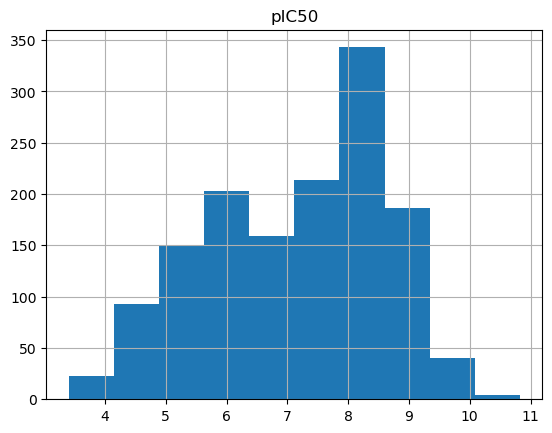

In [42]:
# Look at the distribution of pIC50 values
output_df.hist(column="pIC50")  # Looks like two normal distributions overlapping

In [43]:
# Bring in RDKit and look at structures with highest pIC50 values

# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL2347725,0.015,nM,10.823909,
1,CHEMBL2347722,0.021,nM,10.677781,
2,CHEMBL2347711,0.064,nM,10.193820,
3,CHEMBL2347723,0.064,nM,10.193820,
4,CHEMBL2347719,0.110,nM,9.958607,

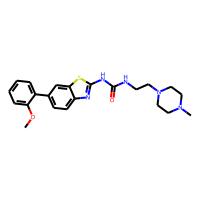
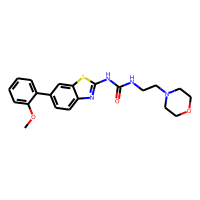
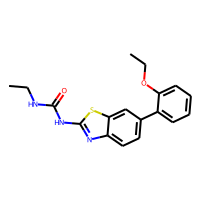
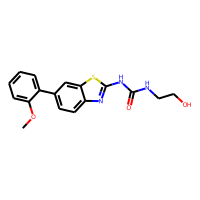
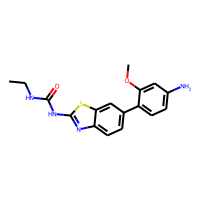

In [45]:
# Look at 5 molecules with highest pIC50 values
output_df.drop("smiles", axis=1).head(5)

In [46]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (1415, 5)


In [47]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL2347725,0.015,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCN(C)CC3)sc2c1,10.823909
1,CHEMBL2347722,0.021,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCN3CCOCC3)sc2c1,10.677781
2,CHEMBL2347711,0.064,nM,CCNC(=O)Nc1nc2ccc(-c3ccccc3OCC)cc2s1,10.193820
3,CHEMBL2347723,0.064,nM,COc1ccccc1-c1ccc2nc(NC(=O)NCCO)sc2c1,10.193820
4,CHEMBL2347719,0.110,nM,CCNC(=O)Nc1nc2ccc(-c3ccc(N)cc3OC)cc2s1,9.958607


In [49]:
# We already know that imatinib (CHEMBL941) binds to the target, so a good sanity
# check is that is in our output data
output_df[output_df['molecule_chembl_id'] == 'CHEMBL941']

,molecule_chembl_id,IC50,units,smiles,pIC50
713,CHEMBL941,38.0,nM,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...,7.420216


In [50]:
# Save in this directory as csv
output_df.to_csv('ABL_compounds.csv')

### At this point, I have an IC50 of 38 nM (0.038 $\mu$M) for imatinib with the target having the same reference sequence as in PDB ID 2HYY. 

### [This reference](https://www.cancerrxgene.org/compound/Imatinib/34/by-tissue?tissue=PANCANCER&screening_set=GDSC1) gives a range from 0.0279 $\mu$M to 140 $\mu$M across all tissue types. 

### It can be seen that the IC50 values for chronic myelogenous leukemia (CML) and acute lymphoblastic leukemia (ALL) are especially low, are the cancer types targeted most effectively by imatinib, and are of the same order of magnitude as the number I presented here.